In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data loading

In [2]:
import pandas as pd
from PIL import Image
import numpy as np
import pickle as pkl
from sklearn.linear_model import Ridge
import sklearn.metrics
import math
import os
import matplotlib.pyplot as plt
import cv2
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms

In [3]:
response_data = pd.read_parquet("/content/drive/MyDrive/Stanford PhD/First Year/Deep learning/natural_scenes_demo/response_data.parquet")
response_data = response_data.drop(columns = ['voxel_id'])
metadata = pd.read_csv("/content/drive/MyDrive/Stanford PhD/First Year/Deep learning/natural_scenes_demo/metadata.csv")
stimulus_data = pd.read_csv("/content/drive/MyDrive/Stanford PhD/First Year/Deep learning/natural_scenes_demo/stimulus_data.csv")

In [4]:
# Modify stimulus_data to contain the correct image path
folder_pth = "/content/drive/MyDrive/Stanford PhD/First Year/Deep learning/natural_scenes_demo/training_imgs/stimulus_set/"
new_image_path = []

for i in range(950):
  new_image_path.append(folder_pth + stimulus_data["image_path"][i].split("/")[-1])

folder_pth = "/content/drive/MyDrive/Stanford PhD/First Year/Deep learning/natural_scenes_demo/testing_imgs/stimulus_set/"
for i in range(950, 1000):
  new_image_path.append(folder_pth + stimulus_data["image_path"][i].split("/")[-1])

stimulus_data["image_path"] = new_image_path

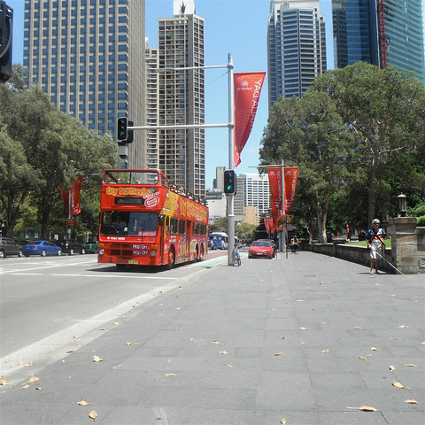

In [10]:
# To select an image
img_num = 953
img = Image.open(stimulus_data["image_path"][img_num])
img_name = stimulus_data["image_id"][img_num]
img

In [11]:
# To select voxel response for the image
voxels = response_data[img_name].to_numpy()

In [12]:
# To select the sentence description
sentence = stimulus_data["coco_supercategs"][img_num] #coco_captions

## Organizing training and testing data

In [13]:
# Collecting all categories
all_categs = set()
for categs in stimulus_data["coco_supercategs"]:
  categs = categs.strip('][').split(', ')
  for categ in categs:
    all_categs.add(categ)

In [14]:
all_categs

{"'accessory'",
 "'animal'",
 "'appliance'",
 "'electronic'",
 "'food'",
 "'furniture'",
 "'indoor'",
 "'kitchen'",
 "'outdoor'",
 "'person'",
 "'sports'",
 "'vehicle'"}

In [15]:
Y_all = []

total_categs = len(all_categs)
categ_to_indx = { categ : i for i, categ in enumerate(all_categs) }

for categs in stimulus_data["coco_supercategs"]:
  one_hot = np.zeros((total_categs,))
  categs = categs.strip('][').split(', ')

  for categ in categs:
    one_hot[categ_to_indx[categ]] = 1
  Y_all.append(one_hot)

Y_all = np.array(Y_all)

In [16]:
X_all = []

for image_id in stimulus_data["image_id"]:
  X_all.append(response_data[image_id].to_numpy())

X_all = np.array(X_all)

In [17]:
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch.optim import Adam
from torch.autograd import Variable

def get_train_test(X_all, Y_all, num_train = 950):
  indices = np.arange(1000)
  training_idx, test_idx = indices[:num_train], indices[num_train:]
  X_train, X_test = torch.tensor(X_all[training_idx,:]), torch.tensor(X_all[test_idx,:])
  y_train, y_test = torch.tensor(Y_all[training_idx,:]), torch.tensor(Y_all[test_idx,:])

  train, test = TensorDataset(X_train,y_train), TensorDataset(X_test,y_test) 
  train_loader, test_loader = DataLoader(train, batch_size = 3), DataLoader(test)  # create your dataloader

  images_pth = stimulus_data['image_name']
  train_images, test_images = images_pth[training_idx], images_pth[test_idx]

  return train_loader, test_loader, train_images, test_images

## Defining model

In [18]:
import torchvision.models as models
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision
import torch
from torchvision.io.image import read_image
from torchvision.transforms.functional import to_pil_image
import numpy as np

In [19]:
class categorynet(nn.Module):
  def __init__(self):
      super(categorynet, self).__init__()

      self.fc1 = nn.Sequential(nn.Linear(8461, 128 * 16 * 16))

      self.deconv1 = nn.Sequential(nn.ConvTranspose2d(128, 64, 5, stride = 3, padding = 1), nn.BatchNorm2d(64), nn.ReLU(True))
      self.deconv2 = nn.Sequential(nn.ConvTranspose2d(64, 32, 5, stride = 3, padding = 1), nn.BatchNorm2d(32), nn.ReLU(True))
      self.img_gen = nn.Sequential(nn.Conv2d(32, 3, 1, stride = 1, padding = 0), nn.BatchNorm2d(3), nn.ReLU(True))
      self.conv1 = nn.Sequential(nn.Conv2d(3, 6, kernel_size=5, stride=3, padding=1), nn.BatchNorm2d(6), nn.ReLU(True))
      self.conv2 = nn.Sequential(nn.Conv2d(6, 6, kernel_size=5, stride=3, padding=1), nn.BatchNorm2d(6), nn.ReLU(True))
      self.fc2 = nn.Sequential(nn.Linear(6*16*16, 12), nn.Sigmoid())

  def forward(self, input):
      x = self.fc1(input)
      x = x.reshape(x.shape[0], 128, 16, 16)
      x = self.deconv1(x)
      x = self.deconv2(x)
      x = self.img_gen(x)
      x = self.conv1(x)   
      x = self.conv2(x)            
      x = x.reshape(x.shape[0], 6*16*16)
      x = self.fc2(x)
      
      return x

categoryNet = categorynet().cuda()
categoryNet.train()

categorynet(
  (fc1): Sequential(
    (0): Linear(in_features=8461, out_features=32768, bias=True)
  )
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (img_gen): Sequential(
    (0): Conv2d(32, 3, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequen

In [23]:
from torchsummary import summary

In [24]:
summary(categoryNet, input_size=(1, 8461))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 1, 32768]     277,282,816
   ConvTranspose2d-2           [-1, 64, 48, 48]         204,864
       BatchNorm2d-3           [-1, 64, 48, 48]             128
              ReLU-4           [-1, 64, 48, 48]               0
   ConvTranspose2d-5         [-1, 32, 144, 144]          51,232
       BatchNorm2d-6         [-1, 32, 144, 144]              64
              ReLU-7         [-1, 32, 144, 144]               0
            Conv2d-8          [-1, 3, 144, 144]              99
       BatchNorm2d-9          [-1, 3, 144, 144]               6
             ReLU-10          [-1, 3, 144, 144]               0
           Conv2d-11            [-1, 6, 48, 48]             456
      BatchNorm2d-12            [-1, 6, 48, 48]              12
             ReLU-13            [-1, 6, 48, 48]               0
           Conv2d-14            [-1, 6,

## Inputting to the model

In [24]:
datapoint = torch.tensor(X_all[0][None, ...]).float().cuda()

In [25]:
res = categoryNet(datapoint)

## Training the model

In [26]:
loss_fn = nn.BCELoss()
optimizer = Adam(categoryNet.parameters(), lr=0.001)

In [27]:
# Function to save the model
def saveModel(train_loss):
    path = "./myFirstModel.pth"
    torch.save(categoryNet.state_dict(), path)
    np.save("./loss.npy", np.array(train_loss))

In [28]:
def testAccuracy(test_loader, device, threshold = 0.5):
    
    categoryNet.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            fMRI, categories = data
            # run the model on the test set to predict labels
            fMRI = Variable(fMRI.to(device))
            categories = Variable(categories.to(device))

            outputs = categoryNet(fMRI.float())
            # the label with the highest energy will be our prediction
            predicted = outputs.data.cpu().numpy() > threshold
            actual = categories.cpu().numpy() > threshold

            total += 1
            if np.array_equal(predicted, actual):
              accuracy += 1
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)

In [32]:
def train(train_loader, test_loader, num_epochs):

    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")

    # Convert model parameters and buffers to CPU or Cuda
    categoryNet.to(device)

    train_loss = []

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0

        for i, (fMRI, categories) in enumerate(train_loader, 0):

            fMRI = Variable(fMRI.to(device)).float()
            categories = Variable(categories.to(device)).float()

            optimizer.zero_grad()
            outputs = categoryNet(fMRI)
            loss = loss_fn(outputs, categories)

            batch_loss_value = loss.item()
            loss.backward()
            optimizer.step()

            train_loss.append(batch_loss_value)
            
            running_loss += loss.item()   
            if i % 90 == 89:    
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 90))
                # zero the loss
                running_loss = 0.0

        accuracy = testAccuracy(test_loader, device)
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
        saveModel(train_loss)

In [33]:
train_loader, test_loader, train_images, test_images = get_train_test(X_all, Y_all, 950)

In [34]:
num_epochs = 100
train(train_loader, test_loader, num_epochs)

The model will be running on cuda:0 device
[1,    90] loss: 0.336
[1,   180] loss: 0.360
[1,   270] loss: 0.289
For epoch 1 the test accuracy over the whole test set is 26 %
[2,    90] loss: 0.229
[2,   180] loss: 0.249
[2,   270] loss: 0.203
For epoch 2 the test accuracy over the whole test set is 28 %
[3,    90] loss: 0.165
[3,   180] loss: 0.182
[3,   270] loss: 0.132
For epoch 3 the test accuracy over the whole test set is 32 %
[4,    90] loss: 0.113
[4,   180] loss: 0.142
[4,   270] loss: 0.108
For epoch 4 the test accuracy over the whole test set is 32 %
[5,    90] loss: 0.103
[5,   180] loss: 0.111
[5,   270] loss: 0.090
For epoch 5 the test accuracy over the whole test set is 28 %
[6,    90] loss: 0.073
[6,   180] loss: 0.066
[6,   270] loss: 0.066
For epoch 6 the test accuracy over the whole test set is 40 %
[7,    90] loss: 0.051
[7,   180] loss: 0.050
[7,   270] loss: 0.054
For epoch 7 the test accuracy over the whole test set is 36 %
[8,    90] loss: 0.052
[8,   180] loss: 

KeyboardInterrupt: ignored

## Plotting training error

In [51]:
train_loss = np.load("/content/drive/MyDrive/Stanford PhD/loss.npy")
batch_loss = []

In [52]:
c = 0
sum_= 0
for i in range(len(train_loss)):
  c += 1
  sum_ += train_loss[i]

  if c == 317:
    batch_loss.append(sum_/c)
    c = 0
    sum_ = 0

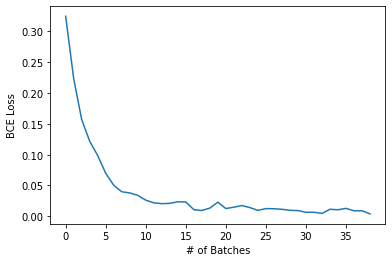

In [53]:
plt.plot(batch_loss)
plt.ylabel("BCE Loss")
plt.xlabel("# of Batches")
plt.show()

## Pix2pix

In [75]:
! git clone https://github.com/GusStgoReyes/CNS-GAN.git

Cloning into 'CNS-GAN'...
remote: Enumerating objects: 209, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 209 (delta 6), reused 18 (delta 6), pack-reused 186
Receiving objects: 100% (209/209), 2.08 MiB | 13.30 MiB/s, done.
Resolving deltas: 100% (107/107), done.


In [76]:
! pip3 install -r CNS-GAN/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 7.7 MB/s 
     |████████████████████████████████| 55 kB 4.3 MB/s 
  Created wheel for visdom: filename=visdom-0.2.3-py3-none-any.whl size=1417107 sha256=b423927ad8097014fc56b3afa99161f981503db112ea488ad1f5f6842b8988a5
  Stored in directory: /root/.cache/pip/wheels/4d/73/32/0bbe55d2dccb9d80d3f020f474c15a5a1eef232817dcebe776
Successfully built visdom


In [74]:
! git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.git

Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2503, done.
remote: Total 2503 (delta 0), reused 0 (delta 0), pack-reused 2503
Receiving objects: 100% (2503/2503), 8.19 MiB | 27.24 MiB/s, done.
Resolving deltas: 100% (1570/1570), done.


In [77]:
! mv /content/pytorch-CycleGAN-and-pix2pix/ /content/pix2pix
! mv /content/pix2pix /content/CNS-GAN/reconstruction/pix2pix

In [78]:
! pip3 install -r /content/CNS-GAN/reconstruction/pix2pix/pix2pix/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 4.6 MB/s 
     |████████████████████████████████| 182 kB 68.1 MB/s 
     |████████████████████████████████| 168 kB 70.0 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 168 kB 81.1 MB/s 
     |████████████████████████████████| 166 kB 79.2 MB/s 
     |████████████████████████████████| 166 kB 70.9 MB/s 
     |████████████████████████████████| 162 kB 80.6 MB/s 
     |████████████████████████████████| 162 kB 81.2 MB/s 
     |████████████████████████████████| 158 kB 69.0 MB/s 
     |████████████████████████████████| 157 kB 80.5 MB/s 
     |████████████████████████████████| 157 kB 77.2 MB/s 
     |████████████████████████████████| 157 kB 85.4 MB/s 
     |████████████████████████████████| 157 kB 76.0 MB/s 
     |████████████████████████████████| 157 kB 80.7 MB/s 
     |████████████████████████████

## Generating images in between

In [71]:
trained_categoryNet = categorynet()
trained_categoryNet.load_state_dict(torch.load("/content/drive/MyDrive/Stanford PhD/39iter.pth"))
trained_categoryNet.eval()

categorynet(
  (fc1): Sequential(
    (0): Linear(in_features=8461, out_features=32768, bias=True)
  )
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (img_gen): Sequential(
    (0): Conv2d(32, 3, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequen

In [89]:
activation = []
def get_activation(name):
    def hook(model, input, output):
        activation.append(output.detach())
    return hook

In [73]:
trained_categoryNet.img_gen.register_forward_hook(get_activation('img_gen'))

In [61]:
all_data = TensorDataset(torch.tensor(X_all), torch.tensor(Y_all))
data_loader= DataLoader(all_data)

In [124]:
! mkdir /content/CNS-GAN/tmp
! mkdir /content/CNS-GAN/tmp/train_pix2pix
! mkdir /content/CNS-GAN/tmp/train_pix2pix/stimulus_set
! mkdir /content/CNS-GAN/tmp/train_pix2pix/stimulus_set/train
! mkdir /content/CNS-GAN/tmp/train_pix2pix/stimulus_set/test

In [129]:
pth = "/content/CNS-GAN/tmp/train_pix2pix/stimulus_set/"
for f in os.listdir(pth):
  if f == 'train' or f == 'test':
    pass
  else:
    if int(f[:-4]) > 950:
      os.rename(pth + f, pth + 'test/' + f)
    else:
      os.rename(pth + f, pth + 'train/' + f)

In [115]:
#Producing training images for pix2pix

train_img_path = '/content/CNS-GAN/tmp/train_pix2pix/'
c = 0
for data in data_loader:

  #Original Image
  img_path = stimulus_data["image_path"][c]
  image = Image.open(img_path)
  img = transforms.Resize(256)(image)
  img = transforms.CenterCrop(224)(img)
  img = transforms.ToTensor()(img)
  
  X = (transforms.ToTensor()(transforms.ToPILImage()(img[0]).convert('RGB').resize((144, 144), Image.ANTIALIAS))).numpy()

  # fMRI Image
  fMRI, categories = data
  trained_categoryNet(fMRI.float())

  res_np = activation[-1].numpy()[0, ...]
  res_np = (res_np - np.min(res_np)) / (np.max(res_np) - np.min(res_np))
  res_np *= 255

  X = torch.from_numpy(X)
  Y = torch.from_numpy(res_np)
  activation = []

  z = torch.cat((X, Y), 2)
  img = transforms.ToPILImage()(z).convert('RGB')
  img.save(os.path.join(train_img_path, str(c) + '.jpg'))

  c += 1

In [134]:
! python /content/CNS-GAN/reconstruction/pix2pix/pix2pix/train.py --dataroot /content/CNS-GAN/tmp/train_pix2pix/stimulus_set --name stimulus_set  --model pix2pix --netG unet_128 --direction BtoA --lambda_L1 100 --dataset_mode aligned --norm batch --pool_size 0 --load_size 128 --crop_size 128 --checkpoints_dir /content/CNS-GAN/reconstruction/model/checkpoints --batch_size 1 --n_epochs 50 --n_epochs_decay 50 --lr 0.0002

----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: /content/CNS-GAN/reconstruction/model/checkpoints	[default: ./checkpoints]
           continue_train: False                         
                crop_size: 128                           	[default: 256]
                 dataroot: /content/CNS-GAN/tmp/train_pix2pix/stimulus_set	[default: None]
             dataset_mode: aligned                       
                direction: BtoA                          	[default: AtoB]
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256        

## Plotting results

In [136]:
gan_train_loss = open("/content/CNS-GAN/reconstruction/model/checkpoints/stimulus_set/loss_log.txt","r+")

G_GAN, G_L1, D_real, D_fake = [], [], [], []
epoch = '1,'
c = 0
G_GAN_sum, G_L1_sum, D_real_sum, D_fake_sum = 0, 0, 0, 0

for line in gan_train_loss.readlines()[1:]:
  c += 1

  G_GAN_sum += float(line.split()[9])
  G_L1_sum += float(line.split()[11])
  D_real_sum += float(line.split()[13])
  D_fake_sum += float(line.split()[15])

  if line.split()[1] != epoch:
    G_GAN.append(G_GAN_sum/c)
    G_L1.append(G_L1_sum/c)
    D_real.append(D_real_sum/c)
    D_fake.append(D_fake_sum/c)

    G_GAN_sum, G_L1_sum, D_real_sum, D_fake_sum = 0, 0, 0, 0
    epoch = line.split()[1]
    c = 0

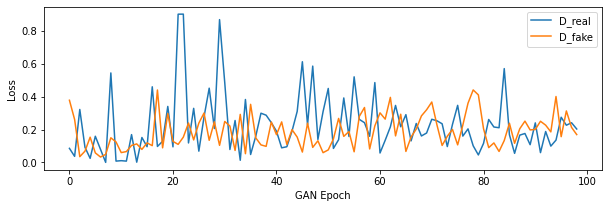

In [137]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(3)
plt.plot(D_real, label = "D_real")
plt.plot(D_fake, label = "D_fake")
plt.xlabel("GAN Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

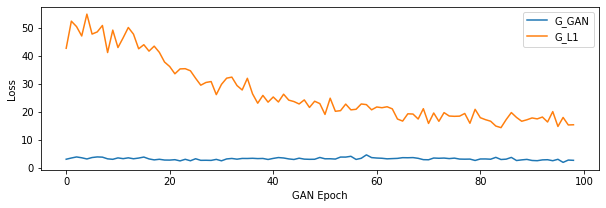

In [138]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(3)
plt.plot(G_GAN, label = "G_GAN")
plt.plot(G_L1, label = "G_L1")
plt.xlabel("GAN Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Visualizing images

In [142]:
! python /content/CNS-GAN/reconstruction/pix2pix/pix2pix/test.py --dataroot "/content/drive/MyDrive/Stanford PhD/First Year/Deep learning/natural_scenes_demo/testing_imgs/stimulus_set/" --name stimulus_set --model test --netG unet_128 --direction BtoA --dataset_mode single --norm batch --load_size 128 --crop_size 128 --checkpoints_dir /content/CNS-GAN/reconstruction/model/checkpoints --results_dir /content/CNS-GAN/reconstruction/results

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: /content/CNS-GAN/reconstruction/model/checkpoints	[default: ./checkpoints]
                crop_size: 128                           	[default: 256]
                 dataroot: /content/drive/MyDrive/Stanford PhD/First Year/Deep learning/natural_scenes_demo/testing_imgs/stimulus_set/	[default: None]
             dataset_mode: single                        
                direction: BtoA                          	[default: AtoB]
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3        